In [20]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from torch.utils.data import Dataset, DataLoader

In [28]:
landmarks = pd.read_csv('augmented_labels.csv')
n=0
img_name = landmarks.iloc[n, 0]
points = landmarks.iloc[n, 1:]
points = np.asarray(points)
points = points.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(points.shape))
print('First 4 Landmarks: {}'.format(points[:4]))

Image name: 00000001_000.jpg
Landmarks shape: (9, 2)
First 4 Landmarks: [[ 45. 126.]
 [109. 128.]
 [ 69. 165.]
 [ 19.  87.]]


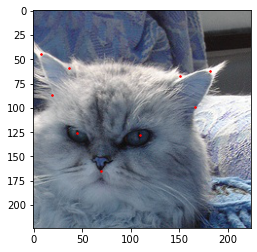

In [29]:
def show_landmarks(image, points):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('cats_augmented', img_name)),
               points)
plt.show()

In [36]:
class CatDataset(Dataset):
    def __init__(self, csv_file, directory):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.directory = directory

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = io.imread(self.directory + self.landmarks_frame.iloc[idx, 0])
        points = landmarks.iloc[idx, 1:]
        points = np.array([points])
        points = points.astype('float').reshape(-1, 2)
        sample = {'image': image, 'points': points}

        return sample

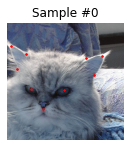

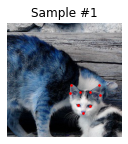

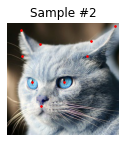

ValueError: num must be 1 <= num <= 3, not 4

In [41]:
cat_dataset = CatDataset(csv_file='augmented_labels.csv', directory='cats_augmented/')

fig = plt.figure()

for i in range(len(cat_dataset)):
    sample = cat_dataset[i]
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [ ]:
dataloader = DataLoader(cat_dataset, batch_size=8, shuffle=True, num_workers=0)